### **Importing Necessary Modules**

In [279]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks, welch
import scipy.integrate

### **Load Bangle Data**

In [280]:
bangle_data = pd.read_csv("HRV-data/bangle.csv")
print(bangle_data.head())

    timestamp_ms  value
0  1724074011462   4334
1  1724074011481   4286
2  1724074011501   4222
3  1724074011520   4174
4  1724074011540   4094


### **Plot Unfiltered Bangle Data**

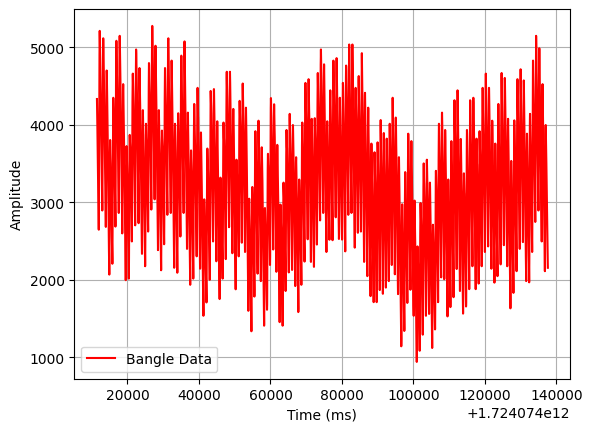

In [281]:
timestamps = bangle_data["timestamp_ms"].to_numpy()
ppg_raw = bangle_data["value"].to_numpy()

plt.plot(timestamps, ppg_raw, c='r', label="Bangle Data")
plt.legend()
plt.grid(True, 'both', 'both')
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.show()

### **Estimating PPG Sampling Rate For Filter Design**
- _Higher sampling rate means more data points are captured, allowing for higher resolution of data, and greater analysis of physiological parameters_
- _Sampling frequency simply means how many samples per second_
- _Knowing the sampling frequency, tells us the time resolution of the PPG signal_
- _Suppose a sampling frequency of 25 Hz would mean one reading every 0.04 seconds_
- _How many times per second a signal is snapshot/captured_

### **Formulas**

**Given timestamps \(t_0, t_1, \dots, t_{N-1}\) in milliseconds:**

1. **Inter-sample intervals** (in seconds):

$$
\Delta t_i = \frac{t_{i+1} - t_i}{1000}, \quad
i = 0,1,\dots,N-2
$$

2. **Mean sampling interval**:

$$
\overline{\Delta t} = \frac{1}{N-1} \sum_{i=0}^{N-2} \Delta t_i
$$

3. **Sampling frequency** (Hz):

$$
f_s = \frac{1}{\overline{\Delta t}}
$$

In [282]:
dt = np.diff(timestamps) / 1000.0
fs = 1 / np.mean(dt)
print(f"Estimated PPG sampling rate: {fs:.1f} Hz")

Estimated PPG sampling rate: 43.9 Hz


### **Finding Peaks In Unfiltered PPG Data**

In [283]:
min_dist = int(0.5 * fs) # the standard formula
peaks, props = find_peaks(ppg_raw, distance=min_dist, height=np.mean(ppg_raw))

### **Plotting Peaks In Unfiltered PPG Data**

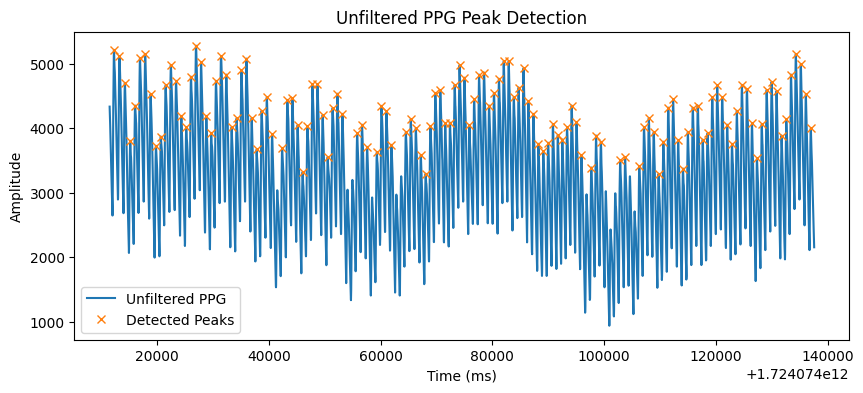

In [284]:
plt.figure(figsize=(10,4))
plt.plot(timestamps, ppg_raw, label="Unfiltered PPG")
plt.plot(timestamps[peaks], ppg_raw[peaks], 'x', label="Detected Peaks")
plt.title("Unfiltered PPG Peak Detection")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

### **Number Of Peaks Detected in the Unfiltered PPG Data**

In [285]:
print(f"Detected {len(peaks)} peaks in the Unfiltered PPG")

Detected 130 peaks in the Unfiltered PPG


### **Creating a Band-pass Filter for Filtering PPG Data**
- _Blocking out frequencies below 0.5 Hz, as that falls under baseline drift (the value a signal exhibits, when no significant change or event is present, essentially the "resting state" of a signal)_
- _Blocking out frequencies above 8 Hz, as those fall under the category of non-cardiac signals or **HIGH FREQUENCY NOISE**_
- _Designing a 3rd order butterworth bandpass filter for pass-band of [0.5, 8]_

In [286]:
lowcut, highcut = 0.5, 8.0
nyq = 0.5 * fs
b, a = butter(3, [lowcut/nyq, highcut/nyq], btype='band')  # Getting numerator b, and denominator a polynomials for the 3rd order IIR filter

### **Filtering the PPG Data**

In [287]:
'filtfilt() applies zero-phase filtering, allowing us to keep the peaks aligned with the raw signal'
ppg_filt = filtfilt(b, a, ppg_raw)  # filtering the raw PPG according to the coefficients from the Butterworth band-pass filter

### **Plotting Filtered PPG Data**

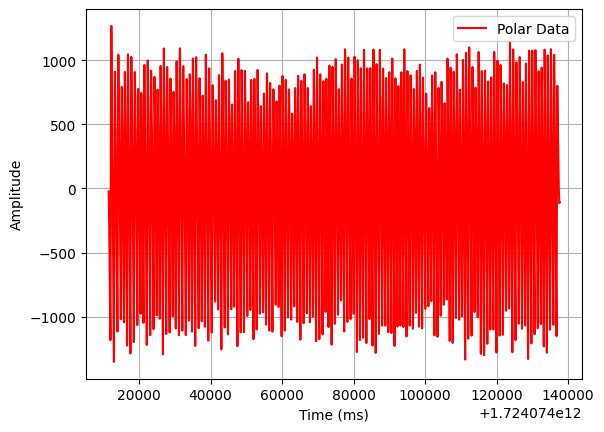

In [288]:
plt.plot(timestamps, ppg_filt, c='r', label="Polar Data")
plt.legend()
plt.grid(True, 'both', 'both')
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.show()

### **Finding Peaks In Filtered PPG Data**

In [289]:
min_dist = int(0.5 * fs) # the standard formula
peaks, props = find_peaks(ppg_filt, distance=min_dist, height=np.mean(ppg_filt))

### **Plotting Peaks In Filtered PPG Data**

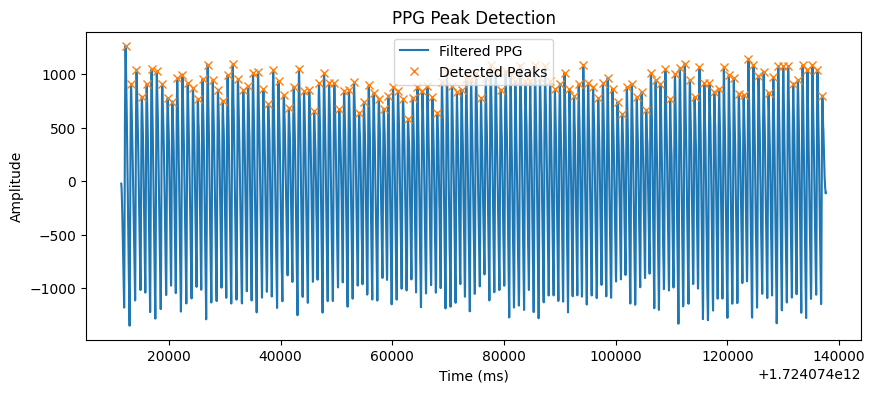

In [290]:
plt.figure(figsize=(10,4))
plt.plot(timestamps, ppg_filt, label="Filtered PPG")
plt.plot(timestamps[peaks], ppg_filt[peaks], 'x', label="Detected Peaks")
plt.title("PPG Peak Detection")
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

### **Number Of Peaks Detected in the Filtered PPG Data**

In [291]:
print(f"Detected {len(peaks)} peaks in the Filtered PPG")

Detected 142 peaks in the Filtered PPG


### **RRIs and IBIs (milliseconds)**

In [292]:
t_peaks = timestamps[peaks]
rri = np.diff(t_peaks)
print(rri)

[996 953 975 855 875 935 974 955 854 875 934 935 954 877 832 914 914 936
 870 854 934 914 973 854 877 911 953 874 874 954 953 894 874 953 893 934
 893 854 914 893 934 893 874 873 894 920 849 854 893 916 890 834 836 891
 912 873 840 847 893 896 892 874 831 892 916 873 830 834 898 891 872 850
 873 893 899 866 895 870 896 893 857 889 888 893 912 855 890 817 895 808
 839 824 880 885 899 867 830 874 890 832 836 882 903 850 844 832 841 869
 872 872 839 891 866 931 852 852 885 905 887 859 846 892 871 921 858 856
 892 906 925 891 852 891 872 890 892 852 831 872 890 892 911]


### **Normal-to-Normal RR Intervals**

In [293]:
rri_normal = rri.copy()
mask1 = (rri_normal >= 300) & (rri_normal <= 2000)
rri_normal = rri_normal[mask1]

diffs = np.abs(np.diff(rri_normal))
mask2 = diffs <= 0.2 * rri_normal[:-1]
rri_normal = rri_normal[1:][mask2]
print(rri_normal)

[953 975 855 875 935 974 955 854 875 934 935 954 877 832 914 914 936 870
 854 934 914 973 854 877 911 953 874 874 954 953 894 874 953 893 934 893
 854 914 893 934 893 874 873 894 920 849 854 893 916 890 834 836 891 912
 873 840 847 893 896 892 874 831 892 916 873 830 834 898 891 872 850 873
 893 899 866 895 870 896 893 857 889 888 893 912 855 890 817 895 808 839
 824 880 885 899 867 830 874 890 832 836 882 903 850 844 832 841 869 872
 872 839 891 866 931 852 852 885 905 887 859 846 892 871 921 858 856 892
 906 925 891 852 891 872 890 892 852 831 872 890 892 911]


### **SDNN (standard deviation of normal-to-normal RR-intervals)**
- After removing noise and non-sinus beats

In [294]:
sdnn = np.std(rri_normal, ddof=1)
print(sdnn)

35.10385340887959


### **SDRR (standard deviation of all RR-intervals)**
- Includes everything, including noise

In [295]:
sdrr = np.std(rri, ddof=1)
print(sdrr)

36.22311811142555


### **The RMSSD (Root Mean Square of Successive Differences) Is Defined As:**

$$
\mathrm{RMSSD} = \sqrt{\frac{1}{N-1} \sum_{i=1}^{N-1} \bigl(RR_{i+1} - RR_i\bigr)^2}
$$

- **\(RR_i\): the \(i\)-th successive R–R interval (in milliseconds)**
- **\(N\): total number of R–R intervals**

In [296]:
diff_rri = np.diff(rri)
rmmsd = np.sqrt(np.mean(diff_rri ** 2))
print(rmmsd)

41.95175800845538


### **The pNN50 (percentage of successive RR-interval differences greater than 50 ms) Is Defined As:**

$$
\mathrm{pNN50} = \frac{\displaystyle\sum_{i=1}^{N-1} \mathbb{I}\bigl(\lvert RR_{i+1} - RR_{i}\rvert > 50\text{ ms}\bigr)}{N - 1} \times 100\%
$$

- **\(RR_i\): the \(i\)-th successive R–R interval (in milliseconds)**
- **\(N\): total number of R–R intervals**
- **1 if condition is True, 0 otherwise**

In [297]:
pnn50 = (np.sum(np.abs(diff_rri) > 50) / len(diff_rri)) * 100
print(pnn50)

22.857142857142858


### **HR Max, HR Min and HR Range**

In [298]:
hr = 60000 / rri
hr_range = np.max(hr) - np.min(hr)
print(hr.max())
print(hr.min())
print(hr_range)

74.25742574257426
60.24096385542169
14.016461887152566
